In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go

from tensorflow import keras # for building Neural Networks
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras import layers
from keras.layers import Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network

In [7]:
data = pd.read_csv("covid_19_continent.csv").rename(columns={
        "Unnamed: 0": "Date",
        "index": "Date"
    }).set_index("Date")
data.index = pd.to_datetime(data.index, format="%Y-%m-%d")

data.head()

,Africa,Americas,Asia,Boat,Europe,Oceania
Date,,,,,,
2020-01-22,0,1,556,0,0,0
2020-01-23,0,1,654,0,0,0
2020-01-24,0,2,937,0,2,0
2020-01-25,0,2,1428,0,3,0
2020-01-26,0,6,2105,0,3,4


In [19]:
df = data.diff().iloc[1:]
df.head(3)

,Africa,Americas,Asia,Boat,Europe,Oceania
Date,,,,,,
2020-01-23,0.0,0.0,98.0,0.0,0.0,0.0
2020-01-24,0.0,1.0,283.0,0.0,2.0,0.0
2020-01-25,0.0,0.0,491.0,0.0,1.0,0.0


In [9]:
px.line(data)

In [10]:
px.line(data.diff())

In [14]:
df = df.reset_index()

In [20]:
df

,Africa,Americas,Asia,Boat,Europe,Oceania
Date,,,,,,
2020-01-23,0.0,0.0,98.0,0.0,0.0,0.0
2020-01-24,0.0,1.0,283.0,0.0,2.0,0.0
2020-01-25,0.0,0.0,491.0,0.0,1.0,0.0
2020-01-26,0.0,4.0,677.0,0.0,0.0,4.0
2020-01-27,0.0,0.0,807.0,0.0,1.0,1.0
...,...,...,...,...,...,...
2021-04-06,12115.0,219311.0,243580.0,0.0,130474.0,21.0
2021-04-07,14346.0,241729.0,266358.0,0.0,161655.0,258.0
2021-04-08,19713.0,259449.0,278213.0,0.0,282259.0,216.0


In [99]:
def shaping(datain, timestep):

    # Convert input dataframe to array and flatten
    arr = datain.to_numpy().flatten() 

    cnt=0
    for mth in range(0, len(arr)-(2*timestep)+1): # Define range 
        cnt = cnt+1 # Gives us the number of samples. Later used to reshape the data
        X_start = mth # Start month for inputs of each sample
        X_end = mth + timestep # End month for inputs of each sample
        Y_start = mth + timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
        Y_end = mth + 2 * timestep # End month for targets of each sample

        # Assemble input and target arrays containing all samples
        if mth == 0:
            X_comb = arr[X_start:X_end]
            Y_comb = arr[Y_start:Y_end]
        else: 
            X_comb = np.append(X_comb, arr[X_start:X_end])
            Y_comb = np.append(Y_comb, arr[Y_start:Y_end])

    # Reshape input and target arrays
    X_out = np.reshape(X_comb, (cnt, timestep, 1))
    Y_out = np.reshape(Y_comb, (cnt, timestep, 1))
    return X_out, Y_out

In [119]:
train_size = int(0.8*len(df))
train = df[["Europe"]].iloc[:train_size]
test = df[["Europe"]].iloc[train_size:]

In [164]:
mean = train.mean(axis=0)
std = train.std(axis=0)

train -= mean
train /= std
test -= mean
test /= std

In [166]:
X_train, y_train = shaping(train, 14)
X_test, y_test = shaping(test, 14)

In [180]:
model = Sequential(name="LSTM-Model") # Model
model.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(LSTM(units=64, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-LSTM-Encoder-Layer')) # Encoder Layer
model.add(RepeatVector(y_train.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(LSTM(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-LSTM-Decoder-Layer')) # Decoder Layer
model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

model.compile(optimizer='rmsprop', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=["mae"], # List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )


In [181]:
model.summary()

Model: "LSTM-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-LSTM-Encoder-Layer   (None, 128)               33792     
 (Bidirectional)                                                 
                                                                 
 Repeat-Vector-Layer (Repea  (None, 14, 128)           0         
 tVector)                                                        
                                                                 
 Hidden-LSTM-Decoder-Layer   (None, 14, 64)            41216     
 (Bidirectional)                                                 
                                                                 
 Output-Layer (TimeDistribu  (None, 14, 1)             65        
 ted)                                                            
                                                                 
Total params: 75073 (293.25 KB)
Trainable params: 75073 

In [182]:
# Entraîner le modèle
history = model.fit(x=X_train, y=y_train, epochs=70, validation_split=0.2)

Epoch 1/70
9/9 [==============================] - 14s 208ms/step - loss: 0.1642 - mae: 0.2350 - val_loss: 0.3693 - val_mae: 0.4805
Epoch 2/70
9/9 [==============================] - 0s 30ms/step - loss: 0.0596 - mae: 0.1462 - val_loss: 0.8017 - val_mae: 0.7620
Epoch 3/70
9/9 [==============================] - 0s 30ms/step - loss: 0.0401 - mae: 0.1471 - val_loss: 1.3392 - val_mae: 1.0172
Epoch 4/70
9/9 [==============================] - 0s 31ms/step - loss: 0.0284 - mae: 0.1165 - val_loss: 1.5083 - val_mae: 1.0875
Epoch 5/70
9/9 [==============================] - 0s 29ms/step - loss: 0.0301 - mae: 0.1253 - val_loss: 1.5107 - val_mae: 1.0872
Epoch 6/70
9/9 [==============================] - 0s 31ms/step - loss: 0.0255 - mae: 0.1156 - val_loss: 1.4614 - val_mae: 1.0673
Epoch 7/70
9/9 [==============================] - 0s 33ms/step - loss: 0.0268 - mae: 0.1222 - val_loss: 1.1539 - val_mae: 0.9363
Epoch 8/70
9/9 [==============================] - 0s 36ms/step - loss: 0.0209 - mae: 0.1000 - v

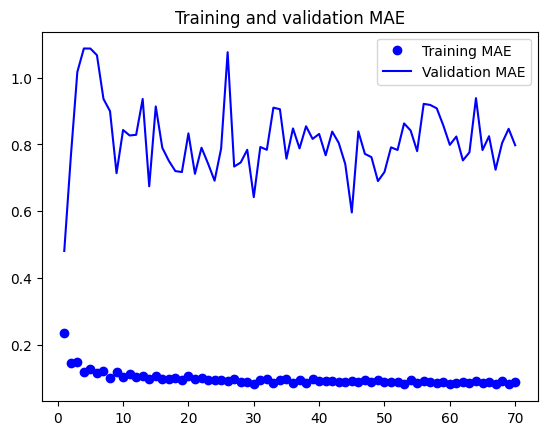

In [183]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [176]:
inputs = keras.Input(shape=(14,1))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mae"])

In [177]:
history = model.fit(x=X_train, y=y_train, epochs=70, validation_split=0.2)

Epoch 1/70
9/9 [==============================] - 6s 122ms/step - loss: 0.4847 - mae: 0.6197 - val_loss: 3.1258 - val_mae: 1.6990
Epoch 2/70
9/9 [==============================] - 0s 16ms/step - loss: 0.3197 - mae: 0.4654 - val_loss: 2.6964 - val_mae: 1.5673
Epoch 3/70
9/9 [==============================] - 0s 15ms/step - loss: 0.2173 - mae: 0.3206 - val_loss: 2.3385 - val_mae: 1.4484
Epoch 4/70
9/9 [==============================] - 0s 17ms/step - loss: 0.1760 - mae: 0.2111 - val_loss: 2.0182 - val_mae: 1.3332
Epoch 5/70
9/9 [==============================] - 0s 15ms/step - loss: 0.1654 - mae: 0.1816 - val_loss: 1.8054 - val_mae: 1.2511
Epoch 6/70
9/9 [==============================] - 0s 15ms/step - loss: 0.1515 - mae: 0.1772 - val_loss: 1.6071 - val_mae: 1.1696
Epoch 7/70
9/9 [==============================] - 0s 15ms/step - loss: 0.1371 - mae: 0.1820 - val_loss: 1.4021 - val_mae: 1.0789
Epoch 8/70
9/9 [==============================] - 0s 15ms/step - loss: 0.1230 - mae: 0.1735 - va

In [179]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 14, 1)]           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 32)                2304      
 onal)                                                           
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2337 (9.13 KB)
Trainable params: 2337 (9.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


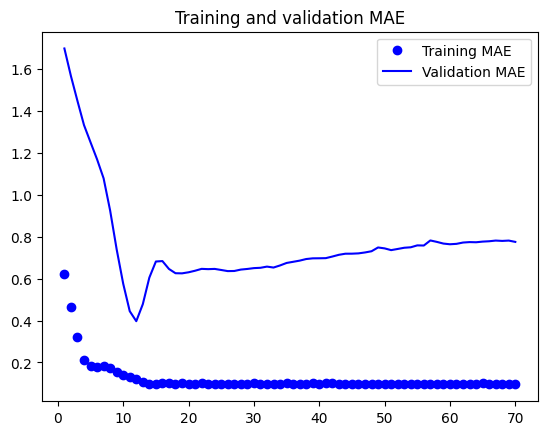

In [178]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()